* Aqui treinaremos uma baseline de PD (Probabilidade de Default) bem simples (regressão logística).

In [2]:
# Imports, carregando dados e escolhendo as features
import pandas as pd
df = pd.read_csv("../data/base_sintetica.csv") # dados sintéticos criados em '01_eda.ipynb'.

features = ['utilizacao','consistencia_6m','ticket_medio_deposito',
            'renda_mensal','atraso30d','limite_atual']

X = df[features]
y = df['default_12m']

len(df), X.head(3), y.mean().round(3) # tamanho, amostra e taxa de default

(1200,
    utilizacao  consistencia_6m  ticket_medio_deposito  renda_mensal  \
 0    0.062993         0.833333             322.316757        2292.0   
 1    0.206490         0.833333              87.121860        1251.0   
 2    0.275449         0.500000             155.198644        2801.0   
 
    atraso30d  limite_atual  
 0          0         800.0  
 1          0         600.0  
 2          0        1000.0  ,
 np.float64(0.076))

In [3]:
# Separando treino e teste
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.25,
                                                    random_state=7,
                                                    stratify=y)
len(X_train), len(X_test)


(900, 300)

In [4]:
# Montando pipeline (padronização + logística) e treinando o modelo
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

base = make_pipeline(StandardScaler(), LogisticRegression(max_iter=2000))
calibrated = CalibratedClassifierCV(base, method='sigmoid', cv=5)
calibrated.fit(X_train, y_train)

,estimator,Pipeline(step..._iter=2000))])
,method,'sigmoid'
,cv,5
,n_jobs,None
,ensemble,'auto'
,copy,True
,with_mean,True
,with_std,True
,penalty,'l2'
,dual,False
,tol,0.0001


In [5]:
# Avaliando AUC no teste
from sklearn.metrics import roc_auc_score

p_test = calibrated.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, p_test)
print("AUC:", round(auc, 3))

AUC: 0.747


In [6]:
# Calibrando
import matplotlib.pyplot as plt

bins = pd.qcut(p_test, q=8, duplicates='drop')
calib = pd.DataFrame({'pd_pred': p_test, 'y': y_test, 'bin': bins}).groupby('bin', observed=True).agg(
    pd_pred_mean=('pd_pred', 'mean'),
    default_rate=('y', 'mean'),
    n=('y', 'size')
).reset_index()

display(calib)

,bin,pd_pred_mean,default_rate,n
0,"(0.014499999999999999, 0.0273]",0.022569,0.026316,38
1,"(0.0273, 0.0361]",0.031578,0.000000,37
2,"(0.0361, 0.0453]",0.040243,0.026316,38
3,"(0.0453, 0.06]",0.051927,0.054054,37
4,"(0.06, 0.0802]",0.069783,0.054054,37
5,"(0.0802, 0.107]",0.095187,0.157895,38
6,"(0.107, 0.142]",0.120498,0.081081,37
7,"(0.142, 0.421]",0.197728,0.210526,38


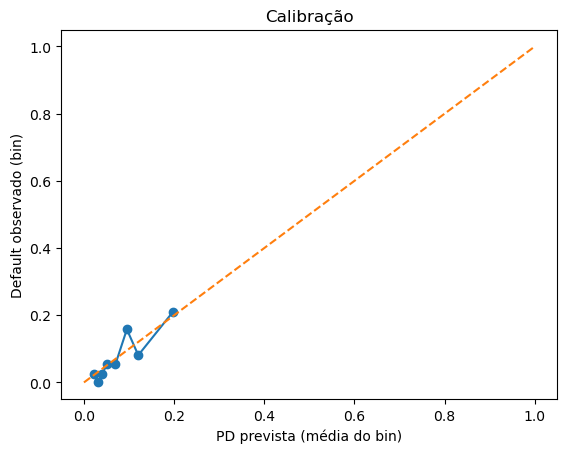

In [7]:
# plot
plt.figure()
plt.plot(calib['pd_pred_mean'], calib['default_rate'], marker='o')
plt.plot([0,1], [0,1], '--')
plt.xlabel('PD prevista (média do bin)')
plt.ylabel('Default observado (bin)')
plt.title('Calibração')
plt.show()

In [8]:
# Erro médio absoluto
err_pp = (calib['pd_pred_mean'] - calib['default_rate']).abs().mean() * 100
print(f"Erro médio absoluto por bin: {err_pp:.1f} p.p.")

Erro médio absoluto por bin: 2.3 p.p.


* Aplicando a política SafeLimit

In [9]:
import pandas as pd
import numpy as np

# Garantindo PD para todo o dataset utilizando o modelo calibrado
df = pd.read_csv("../data/base_sintetica.csv")
features = ['utilizacao','consistencia_6m','ticket_medio_deposito','renda_mensal','atraso30d','limite_atual']
X = df[features]

final_model = calibrated
df['pd_pred'] = final_model.predict_proba(X)[:, 1]

In [10]:
# Buckets por PD
def bucket(pd_):
    if pd_ < 0.03: return 'A'
    if pd_ < 0.06: return 'B'
    if pd_ < 0.10: return 'C'
    return 'D'

df['bucket'] = df['pd_pred'].apply(bucket)

In [11]:
# Elegibilidade mínima (consistência >= 4/6 e ticket >= 5% renda) + caps e fator de risco
def recomendar_limite(row, alpha=5.0):
    b = row['bucket']
    cons_ok = row['consistencia_6m'] >= 2/3
    tick_ok = row['ticket_medio_deposito'] >= 0.05*row['renda_mensal']
    eleg_min = cons_ok and tick_ok
    if (not eleg_min) or b == 'D':
        just = f"Sem aumento: {'consistência insuf.' if not cons_ok else ''}{' ' if (not cons_ok and not tick_ok) else ''}{'ticket insuf.' if not tick_ok else ''}{' | ' if eleg_min and b=='D' else ''}{'bucket D' if b=='D' else ''}"
        return row['limite_atual'], 0.0, False, just.strip()

    base = alpha * row['ticket_medio_deposito']
    cap_renda = 0.5 * row['renda_mensal']
    cap_mult  = 2.0 * row['limite_atual']
    aumento_bruto = min(base, cap_renda)

    fator = {'A':1.0, 'B':0.6, 'C':0.3}[b]
    aumento = aumento_bruto * fator

    aumento_max_por_mult = max(0.0, cap_mult - row['limite_atual'])
    aumento = min(aumento, aumento_max_por_mult)

    novo = row['limite_atual'] + max(0.0, aumento)
    just = f"Aumento: bucket {b}, α={alpha}, base={base:.2f}, caps: renda≤{cap_renda:.2f}, mult≤{cap_mult:.2f}"
    return novo, aumento, True, just

res = df.apply(recomendar_limite, axis=1, result_type='expand')
df['novo_limite'], df['aumento'], df['elegivel'], df['justificativa'] = res[0], res[1], res[2], res[3]

In [12]:
# KPI's principais
pct_elegiveis = df['elegivel'].mean()
aum_med_eleg = df.loc[df['elegivel'], 'aumento'].mean()
print(f"% elegiveis: {pct_elegiveis:.2%}")
print(f"Aumento médio (entre elegíveis): R$ {aum_med_eleg:,.2f}")

# distribuição de buckets e taxa de elegibilidade por bucket
print("\nBuckets (% linhas):")
print((df['bucket'].value_counts(normalize=True).sort_index() * 100).round(1).astype(str) + "%")

print("\nElegibilidade por bucket:")
print(df.groupby('bucket')['elegivel'].mean().apply(lambda x: f"{x:.2%}"))

% elegiveis: 41.50%
Aumento médio (entre elegíveis): R$ 609.31

Buckets (% linhas):
bucket
A    15.6%
B    33.7%
C    24.4%
D    26.3%
Name: proportion, dtype: object

Elegibilidade por bucket:
bucket
A    96.26%
B    62.13%
C    22.87%
D     0.00%
Name: elegivel, dtype: object


In [13]:
# Salvando decisões + amostra
df.to_csv("../data/base_sintetica.csv", index=False)

In [14]:
# Amostra estilizada
cols = ['limite_atual','novo_limite','aumento','renda_mensal','ticket_medio_deposito']

(df[['cliente_id','pd_pred','bucket','elegivel','limite_atual','novo_limite','aumento','justificativa']]
 .head(10)
 .style
 .format({
     'pd_pred': '{:.1%}',
     'limite_atual': 'R$ {:.2f}',
     'novo_limite': 'R$ {:.2f}',
     'aumento': 'R$ {:.2f}',
 })
 .hide(axis='index')  
)

cliente_id,pd_pred,bucket,elegivel,limite_atual,novo_limite,aumento,justificativa
1,1.9%,A,True,R$ 800.00,R$ 1600.00,R$ 800.00,"Aumento: bucket A, α=5.0, base=1611.58, caps: renda≤1146.00, mult≤1600.00"
2,2.3%,A,True,R$ 600.00,R$ 1035.61,R$ 435.61,"Aumento: bucket A, α=5.0, base=435.61, caps: renda≤625.50, mult≤1200.00"
3,5.0%,B,False,R$ 1000.00,R$ 1000.00,R$ 0.00,Sem aumento: consistência insuf.
4,2.2%,A,True,R$ 1000.00,R$ 2000.00,R$ 1000.00,"Aumento: bucket A, α=5.0, base=1934.99, caps: renda≤1525.50, mult≤2000.00"
5,3.0%,A,True,R$ 600.00,R$ 894.98,R$ 294.98,"Aumento: bucket A, α=5.0, base=294.98, caps: renda≤415.50, mult≤1200.00"
6,3.8%,B,True,R$ 500.00,R$ 833.60,R$ 333.60,"Aumento: bucket B, α=5.0, base=741.87, caps: renda≤556.00, mult≤1000.00"
7,6.8%,C,False,R$ 900.00,R$ 900.00,R$ 0.00,Sem aumento: consistência insuf.
8,8.4%,C,False,R$ 500.00,R$ 500.00,R$ 0.00,Sem aumento: consistência insuf.
9,18.9%,D,False,R$ 900.00,R$ 900.00,R$ 0.00,Sem aumento: consistência insuf.bucket D
10,3.4%,B,True,R$ 500.00,R$ 908.30,R$ 408.30,"Aumento: bucket B, α=5.0, base=1316.70, caps: renda≤680.50, mult≤1000.00"


In [15]:
# Salvando pra uso no app
from joblib import dump
import os
os.makedirs("../models", exist_ok=True)
dump(calibrated, "../models/safelimit_pd_calibrated_sigmoid.joblib")
print("Modelo salvo em ../models/safelimit_pd_calibrated_sigmoid.joblib")

Modelo salvo em ../models/safelimit_pd_calibrated_sigmoid.joblib
